In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import random as rn
import tensorflow.keras.backend as K
import utils

In [2]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

In [3]:
fb15k_237 = np.load('./data/fb15k_237.npz', allow_pickle=True)

In [4]:
train = fb15k_237['train']
valid = fb15k_237['valid']
test = fb15k_237['test']

In [5]:
entities = set(np.concatenate((train[:,0], 
                               train[:,2],
                               valid[:,0], 
                               valid[:,2],
                               test[:,0], 
                               test[:,2]), axis=0))

all_relations = set(np.concatenate((train[:,1], valid[:,1], test[:,1]), axis=0))

num_entities = len(entities)
num_relations = len(all_relations)

ent2idx = dict(zip(entities, range(num_entities)))
rel2idx = dict(zip(all_relations, range(num_relations)))

idx2ent = {idx:ent for ent,idx in ent2idx.items()}
idx2rel = {idx:rel for rel,idx in rel2idx.items()}

In [6]:
train2idx = []

for head, rel, tail in train:
    
    head_idx = ent2idx[head]
    tail_idx = ent2idx[tail]
    rel_idx = rel2idx[rel]

    train2idx.append([head_idx, rel_idx, tail_idx])
    
train2idx = np.array(train2idx)

In [7]:
EMBEDDING_SIZE = 50
BATCH_SIZE = 256
NUM_EPOCHS = 200
MARGIN = 3
SQRT_SIZE = 6 / np.sqrt(EMBEDDING_SIZE)

In [8]:
train_data = tf.data.Dataset.from_tensor_slices((train2idx[:,0], train2idx[:,1], train2idx[:,2]))
train_data = train_data.shuffle(buffer_size=50000).batch(BATCH_SIZE)

#exp_decay = tf.keras.optimizers.schedules.ExponentialDecay(.01, 1000, .05)
optimizer = tf.keras.optimizers.SGD(learning_rate=.001)

In [9]:
def get_entity_model():
    
    entity_input = tf.keras.layers.Input(shape=(1,), name='entity_input')
    
    entity_embedding = tf.keras.layers.Embedding(
        input_dim=num_entities,
        output_dim=EMBEDDING_SIZE,
        name='entity_embeddings',
        embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-SQRT_SIZE, maxval=SQRT_SIZE, seed=123)
        )(entity_input)
    
    #conv_1 = tf.keras.layers.Conv1D(filters=64,kernel_size=2, strides=1,padding='same', name='conv_1')(entity_embedding)
    
    #flatten = tf.keras.layers.Flatten()(conv_1)
    
    #dense = tf.keras.layers.Dense(64)(flatten)
    
    model = tf.keras.Model(inputs=entity_input, outputs=entity_embedding)
    
    return model
    
def get_relation_model():
    
    relation_input = tf.keras.layers.Input(shape=(1,), name='relation_input')

    relation_embedding = tf.keras.layers.Embedding(
        input_dim=num_relations,
        output_dim=EMBEDDING_SIZE,
        name='relation_embeddings',
        embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-SQRT_SIZE, maxval=SQRT_SIZE, seed=123)
    )(relation_input)
    
    #conv_1 = tf.keras.layers.Conv1D(filters=64,kernel_size=2, 
    #                                strides=1,padding='same', name='conv_1')(relation_embedding)
    
    #flatten = tf.keras.layers.Flatten()(conv_1)
    
    #dense = tf.keras.layers.Dense(64)(flatten)
    
    model = tf.keras.Model(inputs=relation_input, outputs=relation_embedding)
    
    return model

# def get_embedding_model():
    
#     embedding_input = tf.keras.layers.Input(shape=(1,), name='embedding_input')
    
#     embeddings = tf.keras.layers.Embedding(
#         input_dim=num_items,
#         output_dim=EMBEDDING_SIZE,
#         name='embeddings',
#         embeddings_initializer=tf.keras.initializers.RandomUniform(
#             minval=-SQRT_SIZE, maxval=SQRT_SIZE, seed=123)
#         )(embedding_input)
    
#     model = tf.keras.Model(inputs=embedding_input, outputs=embeddings)
    
#     return model

In [10]:
def dissimilarity(tensors):
    
    head, rel, tail = tensors
    
    return K.sum(K.square(head + rel - tail), axis=1, keepdims=True)

def margin(tensors):
    
    pos, neg = tensors
    
    return K.relu(pos-neg+K.constant(1))

In [11]:
def get_siamese_model():
    
    input_shape = (1,)
    
    pos_head_input = tf.keras.layers.Input(shape=input_shape, name='pos_head_input')
    neg_head_input = tf.keras.layers.Input(shape=input_shape, name='neg_head_input')
    pos_tail_input = tf.keras.layers.Input(shape=input_shape, name='pos_tail_input')
    neg_tail_input = tf.keras.layers.Input(shape=input_shape, name='neg_tail_input')
    relation_input = tf.keras.layers.Input(shape=input_shape, name='relation_input')
    
    entity_model = get_entity_model()
    relation_model = get_relation_model()
    
    pos_h_e = entity_model(pos_head_input)
    neg_h_e = entity_model(neg_head_input)
    pos_t_e = entity_model(pos_tail_input)
    neg_t_e = entity_model(neg_tail_input)
    rel_e   = relation_model(relation_input)
    
    dist = tf.keras.layers.Lambda(dissimilarity, name='dist')
    
    pos = dist([pos_h_e, rel_e, pos_t_e])
    neg = dist([neg_h_e, rel_e, neg_t_e])
    
    #margin_layer = tf.keras.layers.Lambda(margin, name='margin')
    
    #margin_vector = margin_layer([pos, neg])
    
    #preds = tf.keras.layers.Dense(1, activation='sigmoid')(margin_vector)
    
    #preds_out = tf.keras.layers.Flatten()(preds)
    
    siamese_model = tf.keras.Model(
        inputs=[pos_head_input, neg_head_input, pos_tail_input, neg_tail_input, relation_input],
        outputs=[pos, neg]
        )
    
    return siamese_model, entity_model, relation_model

In [12]:
#get labels 1 between positive triples and 0 between negative triples
siamese_model, entity_model, relation_model = get_siamese_model()
#siamese, entity_model = get_siamese_model()

In [14]:
siamese_model.output

[<tf.Tensor 'dist/Identity:0' shape=(None, 1, 50) dtype=float32>,
 <tf.Tensor 'dist_1/Identity:0' shape=(None, 1, 50) dtype=float32>]

In [16]:
losses = []
MARGIN = 2

for epoch in range(NUM_EPOCHS):
    
    for head, rel, tail in train_data:
                
        neg_head, neg_tail = utils.get_negative_triples(head, rel, tail, num_entities=num_entities)
        
        with tf.GradientTape() as tape:
            
            pos, neg = siamese_model([head, neg_head, tail, neg_tail, rel])

            loss = tf.reduce_sum(tf.maximum(pos - neg + MARGIN, 0))
            
        grads = tape.gradient(loss,siamese_model.trainable_variables)
        optimizer.apply_gradients(zip(grads,siamese_model.trainable_variables))
    
    if not epoch % 10:
        
        print('Current loss' , loss.numpy(),'at epoch', epoch)
    
    losses.append(loss.numpy()) 

Current loss 609.36206 at epoch 0
Current loss 329.98303 at epoch 10
Current loss 171.49213 at epoch 20
Current loss 172.64667 at epoch 30
Current loss 98.302536 at epoch 40
Current loss 94.73251 at epoch 50
Current loss 55.281982 at epoch 60
Current loss 69.80447 at epoch 70
Current loss 67.32832 at epoch 80
Current loss 23.868315 at epoch 90
Current loss 38.954155 at epoch 100
Current loss 36.91658 at epoch 110
Current loss 27.223248 at epoch 120
Current loss 32.41407 at epoch 130
Current loss 40.68985 at epoch 140
Current loss 27.854687 at epoch 150
Current loss 17.91468 at epoch 160
Current loss 27.958858 at epoch 170
Current loss 15.168619 at epoch 180
Current loss 34.19442 at epoch 190


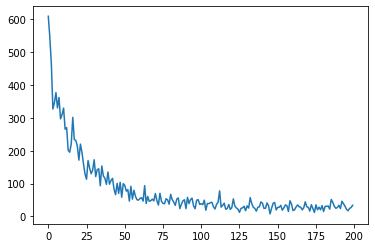

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)

In [19]:
paris_str = '/m/05qtj'
france_str = '/m/0f8l9c'

capital = rel2idx['/location/country/capital']
paris_idx = ent2idx[paris_str]
france_idx = ent2idx[france_str]

paris, france = entity_model(tf.convert_to_tensor([paris_idx, france_idx]))

In [20]:
scores = []

for i in range(len(rel2idx)):
    
    temp_rel = relation_model(i)
    
    score = -np.linalg.norm((paris+temp_rel - france),ord=2)
    
    scores.append(score)
    
idx2rel[np.argmax(scores)]

'/location/capital_of_administrative_division/capital_of./location/administrative_division_capital_relationship/administrative_division'

In [21]:
for i in np.argsort(scores)[-10:]:
    
    print(idx2rel[i])

/base/popstra/celebrity/dated./base/popstra/dated/participant
/education/field_of_study/students_majoring./education/education/major_field_of_study
/base/aareas/schema/administrative_area/administrative_parent
/people/person/spouse_s./people/marriage/spouse
/location/hud_county_place/county
/influence/influence_node/peers./influence/peer_relationship/peers
/music/performance_role/guest_performances./music/recording_contribution/performance_role
/celebrities/celebrity/celebrity_friends./celebrities/friendship/friend
/base/biblioness/bibs_location/country
/location/capital_of_administrative_division/capital_of./location/administrative_division_capital_relationship/administrative_division


In [ ]:
# head_input = siamese.get_layer('pos_head_input')(head)
# tail_input = siamese.get_layer('pos_tail_input')(tail)
# rel_input = siamese.get_layer('relation_input')(rel)

# h = embedding(head_input)
# t = embedding(tail_input)
# r = relation(rel_input)

# neg_head_i = siamese.get_layer('neg_head_input')(neg_head)
# neg_tail_i = siamese.get_layer('neg_tail_input')(neg_tail)

# n_h = embedding(neg_head_i)
# n_t = embedding(neg_tail_i)